# SMC samplers

This tutorial gives a basic introduction to SMC samplers, and explains how to run the SMC samplers already implemented in particles. For a more advanced tutorial on how to design new SMC samplers, see the next tutorial. For more background on SMC samplers, check Chapter 17 of the book.

## SMC samplers: what for? 

A SMC sampler is a SMC algorithm that samples from a sequence of probability distributions $\pi_t$, $t=0,\ldots,T$ (and compute their normalising constants). Sometimes one is genuinely interested in each $\pi_t$; more often one is interested only in the final distribution $\pi_T$. In the latter case, the sequence is purely instrumental.

Examples of SMC sequences are: 

1. $\pi_t(\theta) = p(\theta|y_{0:t})$, the Bayesian posterior distribution of parameter $\theta$ given data $y_{0:t}$, for a certain model. 

2. A tempering sequence, $\pi_t(\theta) \propto \nu(\theta) L(\theta)^{\gamma_t}$ ,where the $\gamma_t$'s form an increasing sequence of exponents: $0=\gamma_0 < \ldots < \gamma_T=1$. You can think of $\nu$ being the prior, $L$ the likelihood function, and $\pi_T$ the posterior. However, more generally, tempering is a way to interpolate between any two distributions, $\nu$ and $\pi$, with $\pi(\theta) \propto \nu(\theta) L(\theta)$. 

We discuss first how to specify a sequence of the first type.

## Defining a Bayesian model

To define a particular Bayesian model, you must subclass `StaticModel`, and define method `logpyt`, which evaluates the log-likelihood of datapoint $Y_t$ given parameter $\theta$ and past datapoints $Y_{0:t-1}$. Here is a simple example: 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats

import particles
from particles import smc_samplers as ssp
from particles import distributions as dists

class ToyModel(ssp.StaticModel):
    def logpyt(self, theta, t):  # density of Y_t given theta and Y_{0:t-1}
        return stats.norm.logpdf(self.data[t], loc=theta['mu'],
                                 scale = theta['sigma'])

In words, we are considering a model where the observations are $Y_t\sim N(\mu, \sigma^2)$ (independently). The parameter is $\theta=(\mu, \sigma)$. Note the fields notation; more about this later. 

Class `ToyModel` implicitely defines the  likelihood of the considered model for any sample size (since the likelihood at time $t$ is $p^\theta(y_{0:t})=\prod_{s=0}^t p^\theta(y_s|y_{0:s-1})$, and method `logpyt` defines each factor in this product; note that $y_s$ does not depend on the past values in our particular example). We now define the data and the prior: 

In [2]:
T = 1000
my_data = stats.norm.rvs(loc=3.14, size=T)  # simulated data
my_prior = dists.StructDist({'mu': dists.Normal(scale=10.),
                             'sigma': dists.Gamma()})

For more details about to define prior distributions, see the documentation of module `distributions`, or the previous [tutorial on Bayesian estimation of state-space models](Bayes_estimation_ssm.ipynb). Now that we have everything, let's specify our static model: 

In [3]:
my_static_model = ToyModel(data=my_data, prior=my_prior)

This time, object `my_static_model` entirely defines the posterior. 

In [4]:
thetas = my_prior.rvs(size=5) 
my_static_model.logpost(thetas, t=2)  
# if t is omitted, gives the full posterior

array([-121.63754951,  -61.50775307, -618.56256159,   -9.46502021,
        -83.36362417])

The input of `logpost` and output of `myprior.rvs()` are [structured array](https://docs.scipy.org/doc/numpy/user/basics.rec.html), that is, arrays with fields:

In [5]:
thetas['mu'][0]

-12.196688463219886

Typically, you won't need to call `logpost` yourself, this will be done by the SMC sampler for you. 

## IBIS

IBIS (iterated batch importance sampling) is the standard name for a SMC sampler that tracks a sequence of partial posterior distributions; i.e. $\pi_t$ is $p(\theta|y_{0:t})$, for $t=0,1,\ldots$. 

Module `smc_samplers` defines `IBIS` as a subclass of `FeynmanKac`. 

In [6]:
my_ibis = ssp.IBIS(my_static_model, len_chain=50)
my_alg = particles.SMC(fk=my_ibis, N=20, 
                       store_history=True, verbose=True)
my_alg.run()

t=0, ESS=73.12
t=1, Metropolis acc. rate (over 49 steps): 0.242, ESS=508.20
t=2, ESS=263.54
t=3, Metropolis acc. rate (over 49 steps): 0.229, ESS=611.10
t=4, ESS=443.78
t=5, Metropolis acc. rate (over 49 steps): 0.243, ESS=878.01
t=6, ESS=699.03
t=7, ESS=551.34
t=8, ESS=699.48
t=9, ESS=573.34
t=10, ESS=648.59
t=11, ESS=629.93
t=12, ESS=591.22
t=13, ESS=557.86
t=14, ESS=512.58
t=15, ESS=483.54
t=16, Metropolis acc. rate (over 49 steps): 0.347, ESS=965.63
t=17, ESS=905.47
t=18, ESS=920.15
t=19, ESS=836.14
t=20, ESS=823.75
t=21, ESS=881.90
t=22, ESS=857.63
t=23, ESS=839.66
t=24, ESS=776.52
t=25, ESS=699.29
t=26, ESS=627.02
t=27, ESS=550.31
t=28, ESS=547.85
t=29, ESS=601.52
t=30, ESS=626.34
t=31, ESS=646.29
t=32, ESS=668.45
t=33, ESS=701.96
t=34, ESS=691.67
t=35, ESS=673.17
t=36, ESS=668.28
t=37, ESS=643.42
t=38, ESS=634.95
t=39, ESS=630.10
t=40, ESS=611.20
t=41, ESS=612.01
t=42, ESS=596.82
t=43, ESS=588.45
t=44, ESS=562.75
t=45, ESS=535.02
t=46, ESS=545.87
t=47, ESS=547.88
t=48, ESS=541.2

t=613, Metropolis acc. rate (over 49 steps): 0.326, ESS=999.40
t=614, ESS=998.52
t=615, ESS=982.61
t=616, ESS=966.38
t=617, ESS=970.51
t=618, ESS=976.51
t=619, ESS=986.39
t=620, ESS=985.30
t=621, ESS=991.79
t=622, ESS=993.50
t=623, ESS=921.19
t=624, ESS=922.96
t=625, ESS=882.15
t=626, ESS=897.28
t=627, ESS=903.86
t=628, ESS=916.69
t=629, ESS=930.38
t=630, ESS=941.15
t=631, ESS=947.94
t=632, ESS=945.98
t=633, ESS=951.50
t=634, ESS=962.34
t=635, ESS=960.86
t=636, ESS=952.12
t=637, ESS=960.20
t=638, ESS=966.08
t=639, ESS=969.47
t=640, ESS=963.73
t=641, ESS=958.47
t=642, ESS=964.91
t=643, ESS=963.23
t=644, ESS=970.58
t=645, ESS=975.96
t=646, ESS=980.55
t=647, ESS=985.75
t=648, ESS=989.93
t=649, ESS=992.82
t=650, ESS=994.94
t=651, ESS=994.08
t=652, ESS=982.02
t=653, ESS=986.81
t=654, ESS=974.13
t=655, ESS=979.91
t=656, ESS=978.16
t=657, ESS=961.71
t=658, ESS=969.93
t=659, ESS=967.28
t=660, ESS=963.28
t=661, ESS=947.06
t=662, ESS=954.93
t=663, ESS=957.91
t=664, ESS=900.75
t=665, ESS=908.71
t

**Note**: we use option `verbose=True` in `SMC` in order to print some information on the intermediate distributions. 

Since we set `store_history` to `True`, the particles and their weights have been saved at every time (in attribute `hist`, see previous tutorials on smoothing). Let's plot the posterior distributions of $\mu$ and $\sigma$ at various times.

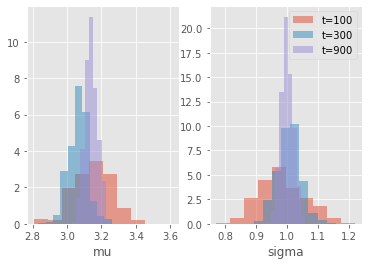

In [7]:
plt.style.use('ggplot')
for i, p in enumerate(['mu', 'sigma']):
    plt.subplot(1, 2, i + 1)
    for t in [100, 300, 900]:
        plt.hist(my_alg.hist.X[t].theta[p], weights=my_alg.hist.wgts[t].W, label="t=%i" % t, 
                 alpha=0.5, density=True)
    plt.xlabel(p)
plt.legend();

As expected, the posterior distribution concentrates progressively around the true values. 

As always, once the algorithm is run, `my_smc.X` contains the final particles. However, object `my_smc.X` is no longer a simple numpy array. It is a `ThetaParticles` object, with attributes:

* `theta`: a structured array (an array with fields); i.e. `my_smc.X.theta['mu']` is a (N,) array that contains the the $\mu-$component of the $N$ particles; 
* `lpost`: a 1D numpy array that contains the target (posterior) log-density of each of the particles;
* `shared`: a dictionary that contains "meta-data" on the particles; for instance `shared['acc_rates']` is a list of the acceptance rates of the successive Metropolis steps. 

['24%', '23%', '24%', '35%', '36%', '34%', '32%', '36%', '38%', '33%']


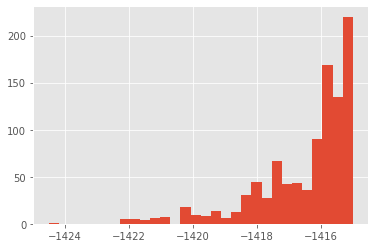

In [8]:
print(["%2.f%%" % (100 * np.mean(r)) for r in my_alg.X.shared['acc_rates']])
plt.hist(my_alg.X.lpost, 30);

You do not need to know much more about class `ThetaParticles` for most practical purposes (see however the documention of module `smc_samplers` if you do want to know more, e.g. in order to implement other classes of SMC samplers).

## Waste-free versus standard SMC samplers

The library now implements by default waste-free SMC ([Dau & Chopin, 2020](https://arxiv.org/abs/2011.02328)), a variant of SMC samplers that keeps all the intermediate Markov steps (rather than "wasting" them). In practice, this means that, in the piece of code above:
* at each time $t$, $N=20$ are resampled, and used as a starting points of the MCMC chains; 
* the MCMC chains are run for 49 iterations, hence the chain length is 50 (parameter ``len_chain=50``)
* and since we keep all the intermediate steps, we get 50*20 = 1000 particles at each iteration. In particular, we do O(1000) operations at each step. (At time 0, we also generate 1000 particles.) 

Thus, the number of particles is actually `N * len_chain`; given this number of particles, the performance typically does not depend too much on `N` and `len_chain`, provided the latter is "big enough" (relative to the mixing of the MCMC kernels).  

See Dau & Chopin (2020) for more details on waste-free SMC. If you wish to run a standard SMC sampler instead, you may set `wastefree=False`, like this:

In [9]:
my_ibis = ssp.IBIS(my_static_model, wastefree=False, len_chain=11)
my_alg = particles.SMC(fk=my_ibis, N=100, store_history=True)
my_alg.run()

This algorithms tracks $N=100$ particles, which are resampled from time to time, and then moved through 10 MCMC steps. (As explained in Dau & Chopin, 2020, you typically get 

## Regarding the MCMC steps

The default MCMC kernel used to move the particles is a Gaussian random walk Metropolis kernel, whose covariance matrix is calibrated automatically to $\gamma$ times of the empirical covariance matrix of the particle sample, where $\gamma=2.38 / \sqrt{d}$ (standard choice in the literature). 

It is possible to specify a different value for $\gamma$, or more generally other types of MCMC moves; for instance the following uses Metropolis kernels based on independent Gaussian proposals: 

In [10]:
mcmc = ssp.ArrayIndependentMetropolis(scale=1.1)
# Independent Gaussian proposal, with mean and variance determined by 
# the particle sample (variance inflated by factor scale=1.1) 
alt_move = ssp.MCMCSequenceWF(mcmc=mcmc)
# This object represents a particular way to apply several MCMC steps 
# in a row. WF = WasteFree
alt_ibis = ssp.IBIS(my_static_model, move=alt_move)
alt_alg = particles.SMC(fk=alt_ibis, N=100,ESSrmin=0.2,
                        verbose=True)
alt_alg.run()

t=0, ESS=38.12
t=1, Metropolis acc. rate (over 9 steps): 0.346, ESS=454.82
t=2, ESS=240.76
t=3, ESS=140.95
t=4, Metropolis acc. rate (over 9 steps): 0.552, ESS=869.26
t=5, ESS=648.88
t=6, ESS=466.32
t=7, ESS=373.66
t=8, ESS=475.67
t=9, ESS=368.07
t=10, ESS=522.30
t=11, ESS=510.36
t=12, ESS=447.12
t=13, ESS=393.78
t=14, ESS=338.68
t=15, ESS=298.87
t=16, ESS=264.89
t=17, ESS=261.89
t=18, ESS=230.94
t=19, ESS=212.88
t=20, ESS=195.59
t=21, Metropolis acc. rate (over 9 steps): 0.808, ESS=947.93
t=22, ESS=844.86
t=23, ESS=932.57
t=24, ESS=944.16
t=25, ESS=913.75
t=26, ESS=895.31
t=27, ESS=830.41
t=28, ESS=794.65
t=29, ESS=788.52
t=30, ESS=825.66
t=31, ESS=848.65
t=32, ESS=856.35
t=33, ESS=771.59
t=34, ESS=792.17
t=35, ESS=805.13
t=36, ESS=734.92
t=37, ESS=668.79
t=38, ESS=686.74
t=39, ESS=710.93
t=40, ESS=693.38
t=41, ESS=719.68
t=42, ESS=658.24
t=43, ESS=667.20
t=44, ESS=599.11
t=45, ESS=542.62
t=46, ESS=576.18
t=47, ESS=599.72
t=48, ESS=605.66
t=49, ESS=620.90
t=50, ESS=626.14
t=51, ESS=62

t=738, ESS=272.21
t=739, ESS=270.30
t=740, ESS=269.49
t=741, ESS=267.49
t=742, ESS=266.09
t=743, ESS=264.21
t=744, ESS=266.49
t=745, ESS=266.05
t=746, ESS=265.71
t=747, ESS=263.81
t=748, ESS=263.30
t=749, ESS=261.90
t=750, ESS=263.02
t=751, ESS=261.47
t=752, ESS=261.19
t=753, ESS=260.58
t=754, ESS=260.23
t=755, ESS=259.85
t=756, ESS=258.09
t=757, ESS=257.40
t=758, ESS=255.69
t=759, ESS=254.09
t=760, ESS=252.53
t=761, ESS=252.19
t=762, ESS=258.73
t=763, ESS=259.23
t=764, ESS=261.68
t=765, ESS=261.40
t=766, ESS=260.60
t=767, ESS=261.24
t=768, ESS=261.12
t=769, ESS=259.22
t=770, ESS=257.43
t=771, ESS=258.65
t=772, ESS=257.84
t=773, ESS=256.45
t=774, ESS=255.00
t=775, ESS=256.23
t=776, ESS=254.48
t=777, ESS=253.50
t=778, ESS=252.17
t=779, ESS=250.97
t=780, ESS=250.15
t=781, ESS=255.53
t=782, ESS=255.40
t=783, ESS=253.78
t=784, ESS=253.64
t=785, ESS=251.92
t=786, ESS=251.07
t=787, ESS=249.87
t=788, ESS=248.96
t=789, ESS=249.16
t=790, ESS=247.50
t=791, ESS=246.43
t=792, ESS=245.60
t=793, ESS

In the future, the package may also implement other type of MCMC kernels such as MALA. It is also possible to define your own MCMC kernels, as explained in the next tutorial. 

For now, note the following practical detail: the algorithm resamples whenever the ESS gets below a certain threshold $\alpha * N$; the default value $\alpha=0.5$, but here we changed it (to $\alpha=0.2$) by setting `ESSrmin=0.2`.

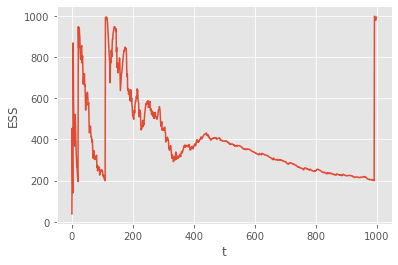

In [11]:
plt.plot(alt_alg.summaries.ESSs)
plt.xlabel('t')
plt.ylabel('ESS');

As expected, the algorithm waits until the ESS is below 200 to trigger a resample-move step.

## SMC tempering

SMC tempering is a SMC sampler that samples iteratively from the following sequence of distributions:

\begin{equation}
\pi_t(\theta) \propto \pi(\theta) L(\theta)^\gamma_t
\end{equation}

with $0=\gamma_0 < \ldots < \gamma_T = 1$. In words, this sequence is a **geometric bridge**, which interpolates between the prior and the posterior. 

SMC tempering implemented in the same was as IBIS: as a sub-class of `FeynmanKac`, whose `__init__` function takes as argument a `StaticModel` object. 

In [15]:
fk_tempering = ssp.AdaptiveTempering(my_static_model)
my_temp_alg = particles.SMC(fk=fk_tempering, N=1000, ESSrmin=1., 
                            verbose=True)
my_temp_alg.run()

t=0, ESS=5000.00, tempering exponent=2.73e-05
t=1, Metropolis acc. rate (over 9 steps): 0.264, ESS=5000.00, tempering exponent=0.000321
t=2, Metropolis acc. rate (over 9 steps): 0.249, ESS=5000.00, tempering exponent=0.0019
t=3, Metropolis acc. rate (over 9 steps): 0.249, ESS=5000.00, tempering exponent=0.00657
t=4, Metropolis acc. rate (over 9 steps): 0.289, ESS=5000.00, tempering exponent=0.0214
t=5, Metropolis acc. rate (over 9 steps): 0.325, ESS=5000.00, tempering exponent=0.0728
t=6, Metropolis acc. rate (over 9 steps): 0.344, ESS=5000.00, tempering exponent=0.245
t=7, Metropolis acc. rate (over 9 steps): 0.343, ESS=5000.00, tempering exponent=0.815
t=8, Metropolis acc. rate (over 9 steps): 0.353, ESS=9667.67, tempering exponent=1


**Note**: Recall that `SMC` resamples every time the ESS drops below value N times option `ESSrmin`; here we set it to to 1, since we want to resample at every time. This makes sense: Adaptive SMC chooses adaptively the successive values of $\gamma_t$ so that the ESS drops to $N/2$ (by default). 

We have not saved the intermediate results this time (option `store_history` was not set) since they are not particularly interesting. Let's look at the final results: 

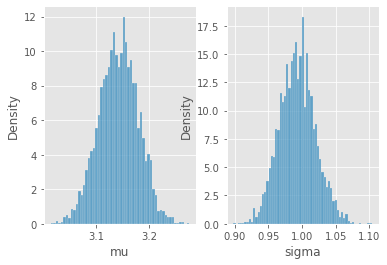

In [13]:
for i, p in enumerate(['mu', 'sigma']):
    plt.subplot(1, 2, i + 1)
    sb.histplot(my_temp_alg.X.theta[p], stat='density')
    plt.xlabel(p)

This looks reasonable!
You can see from the output that the algorithm automatically chooses the tempering exponents $\gamma_1, \gamma_2,\ldots$. In fact, at iteration $t$, the next value for $\gamma$ is set that the ESS drops at most to $N/2$. You can change this particular threshold by passing argument ESSrmin to TemperingSMC. (Warning: do not mistake this with the `ESSrmin` argument of class `SMC`):

In [14]:
lazy_tempering = ssp.AdaptiveTempering(my_static_model, ESSrmin = 0.1)
lazy_alg = particles.SMC(fk=lazy_tempering, N=1000, verbose=True)
lazy_alg.run()

t=0, ESS=1000.00, tempering exponent=0.00121
t=1, Metropolis acc. rate (over 9 steps): 0.242, ESS=1000.00, tempering exponent=0.0239
t=2, Metropolis acc. rate (over 9 steps): 0.359, ESS=1000.00, tempering exponent=0.489
t=3, Metropolis acc. rate (over 9 steps): 0.377, ESS=7525.91, tempering exponent=1


The algorithm progresses faster this time, but the ESS drops more between each step.
Another optional argument for Class `TemperingSMC` is `options_mh`, which works exactly as for `IBIS`, see above. That is, by default, the particles are moved according to a certain (adaptative) number of random walk steps, with a variance calibrated to the particle variance.